## Practica Modelos de Difusión

En esta práctica vamos a aprovechar lo visto en clases anteriores e implementar un modelo de difusión para la generación de imágenes en PyTorch. Recordemos el principio detrás de estos modelos:

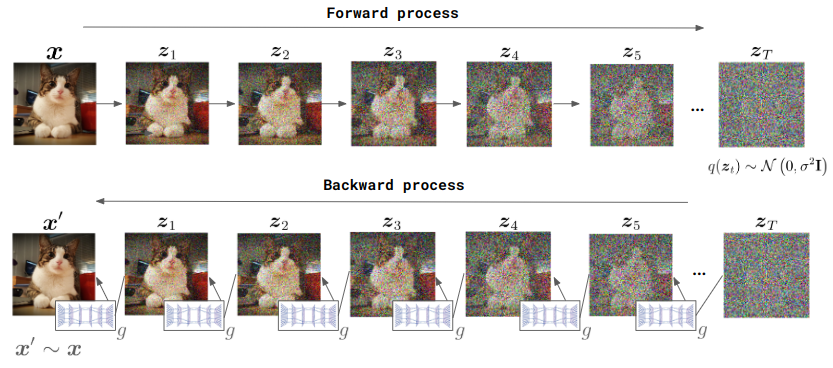

Para entrenar un modelo de difusión vamos a tener que hacer lo siguiente:

- Sampleamos una imagen $\mathbf{x} \in P(\mathbf{X})$ y destruimos información de forma progresiva (*forward process*). Esta destrucción se hace añadiendo ruido siguiendo el *diffusion kernel*.
- Una vez destruida la información entrenamos un modelo de deep learning para que aprenda a, dada una imagen sin información $\mathbf{z}_T$, revertir el proceso de destrucción (*backward process*).

Una vez entrenado el modelo, solo necesitamos generar una $\mathbf{z}_T \sim Norm(0, \mathbf{I})$ y aplicar el *backward process* aprendido por el modelo.

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Es posible entrenar el modelo en CPU pero generalmente los modelos de difusión necesitan de muchas epochs para converger, por lo que se recomienda entrenarlo en GPU.

In [2]:
# Definimos el device sobre el que correr el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Preparación del dataset

Vamos a trabajar con las imágenes de CIFAR10, un dataset que ya hemos visto en clase anteriores. PyTorch ofrece estos datos preparados en forma de `Dataset`.

In [3]:
dataset = torchvision.datasets.CIFAR10(root='./data', download=True)
print('Categorías:', dataset.classes)

100.0%


Categorías: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Para facilitar el aprendizaje, vamos a centrarnos en solo una categoría, por ejemplo gatos, de forma que nuestro modelo generará exclusivamente imágenes de gatos

In [4]:
# Categoria a seleccionar
class_name = 'cat'
class_index = dataset.class_to_idx[class_name]

# Indices de imagenes con la categoria seleccionada
indices = [i for i, label in enumerate(dataset.targets) if label == class_index]

# Actualizamos el dataset
dataset = torch.utils.data.Subset(dataset, indices)

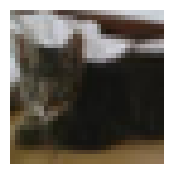

In [5]:
def plot_random_image(data, idx):
    try:
        img, _ = data[idx]
    except:
        img = data[idx]
        
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_random_image(data=dataset, idx=0)

En este caso, a diferencia de otras prácticas, no vamos a necesitar la categoría de las imágenes ya que intentamos aprender un modelo generativo sobre estas imágenes, es decir, vamos a intentar aproximar $P(\mathbf{X})$. En otras prácticas, por ejemplo en las que construimos un modelo de clasificación, intentábamos aprender $P(\mathbf{Y} \mid \mathbf{X})$.

Para preprocesar el dataset vamos a definir un conjunto de operaciones a aplicar a los datos, que se aplicaran al samplear muestras de este.

In [6]:
def transform_dataset(dataset):
    transformations = [
        transforms.ToTensor(), # Convierte de PIL a torch.tensor (con rango [0, 1])
        transforms.Lambda(lambda x: (x * 2) - 1) # Llevamos el rango a [-1, 1]
    ]

    # Componemos las transformaciones
    data_transform = transforms.Compose(transformations)

    # Aplicamos las transformaciones a todos las muestras del dataset
    transformed_dataset = [data_transform(img) for img, _ in dataset]
    return transformed_dataset

In [7]:
dataset = transform_dataset(dataset)

También vamos a definir las operaciones opuestas, para ser capaces de revertir estas transformaciones sobre las predicciones del modelo.

In [8]:
def revert_transform_dataset(dataset):
    transformations = [
        transforms.Lambda(lambda x: (x + 1) / 2), # Llevamos el rango [-1, 1] a [0, 1]
        transforms.Lambda(lambda x: x.permute(1, 2, 0)), # Llevamos los chanels a la ultima dimension
        transforms.Lambda(lambda x: x * 255), # Lo llevamos al rango [0, 255]
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)), # Pasamos de torch.tensor a NumPy
        transforms.ToPILImage() # Pasamos de NumPy a PIL
    ]
    data_transform = transforms.Compose(transformations)
    
    transformed_dataset = [data_transform(img) for img in dataset]
    return transformed_dataset

Una vez definido nuestro `Dataset` base vamos a construir sobre este el correspondiente `DataLoader`

In [9]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### Forward process

Lo primero que necesitamos hacer es implementar el *forward process*. Para ello vamos a definir unos parámetros clave para el modelo de difusión:

- $T$: El número de pasos en el proceso de destrucción de información
- $\beta_0$, $\beta_1$: Los valores de inicio y fin del *noise schedule*. Esta será el resultado de hacer una interpolación lineal entre estos valores.

Recordad que para que $q(\mathbf{z}_{t-1} \mid \mathbf{z}_t) \sim Norm_{\mathbf{z}_{t-1}}$ necesitamos que $T$ sea lo suficientemente grande y $\beta_t$ cercano a cero.

In [10]:
num_timesteps = 100 # T
beta_start, beta_end = 0.001, 0.02 # beta_0, beta_1
beta_schedule = torch.linspace(beta_start, beta_end, num_timesteps) # Noise schedule

In [11]:
beta_schedule[:50]

tensor([0.0010, 0.0012, 0.0014, 0.0016, 0.0018, 0.0020, 0.0022, 0.0023, 0.0025,
        0.0027, 0.0029, 0.0031, 0.0033, 0.0035, 0.0037, 0.0039, 0.0041, 0.0043,
        0.0045, 0.0046, 0.0048, 0.0050, 0.0052, 0.0054, 0.0056, 0.0058, 0.0060,
        0.0062, 0.0064, 0.0066, 0.0068, 0.0069, 0.0071, 0.0073, 0.0075, 0.0077,
        0.0079, 0.0081, 0.0083, 0.0085, 0.0087, 0.0089, 0.0091, 0.0093, 0.0094,
        0.0096, 0.0098, 0.0100, 0.0102, 0.0104])

Para poder desarrollar el *diffusion kernel* necesitamos expresar la *noise schedule* de la siguiente forma:

$$\alpha_t = \prod_{s=1}^{t} 1 - \beta_s$$

In [12]:
alphas_schedule = 1 - beta_schedule
alphas_hat_schedule = torch.cumprod(alphas_schedule, axis=0)

Si recordamos la clase de teoría, habiamos dicho que en el actual desarollo de los modelos de difusión solo modelamos la media de la distribución normal del *backward process*, es decir, dado un modelo de deep learning $f(\cdot, \theta)$ modelamos lo siguiente:

$$q(\mathbf{z}_{t-1} \mid \mathbf{z}_t) \mid Norm_{\mathbf{z}_{t-1}}(f(\mathbf{z}_t, \theta), \sigma^2_t\mathbf{I})$$

Para calcular $\sigma^2_t$, que va a depender del paso $t$ en el que estemos, hacemos lo siguiente:

$$\sigma^2_t = \frac{1-\alpha_{t-1}}{1 - \alpha_t}$$

In [13]:
alphas_hat_schedule_prev = F.pad(alphas_hat_schedule[:-1], (1, 0), value=1.0)
posterior_variance = beta_schedule * (1. - alphas_hat_schedule_prev) / (1. - alphas_hat_schedule) # Calculamos sigma^2_t

Una vez definido esto podemos generar una función que, dado $\mathbf{x}_0$, y apoyándose del *diffusion kernel*, genere la correspondiente variable latente $\mathbf{z}_t$ para cualquier paso $t$ sin necesidad de operar iterativamente a través de $z_{1 \ldots (t-1)}$

In [14]:
def forward_diffusion_sample(x_0, t, alphas_hat_schedule):
    # Generamos una muestra aleatoria de una normal estandar
    random_noise = torch.randn_like(x_0)
    
    # Aplicamos el diffusion kernel
    x_noise = x_0 * np.sqrt(alphas_hat_schedule[t]) + np.sqrt(1 - alphas_hat_schedule[t]) * random_noise
    
    return x_noise, random_noise

A continuación se muestra un ejemplo de este *forward process* para una imagen del dataset que vamos a usar para entrenar al modelo

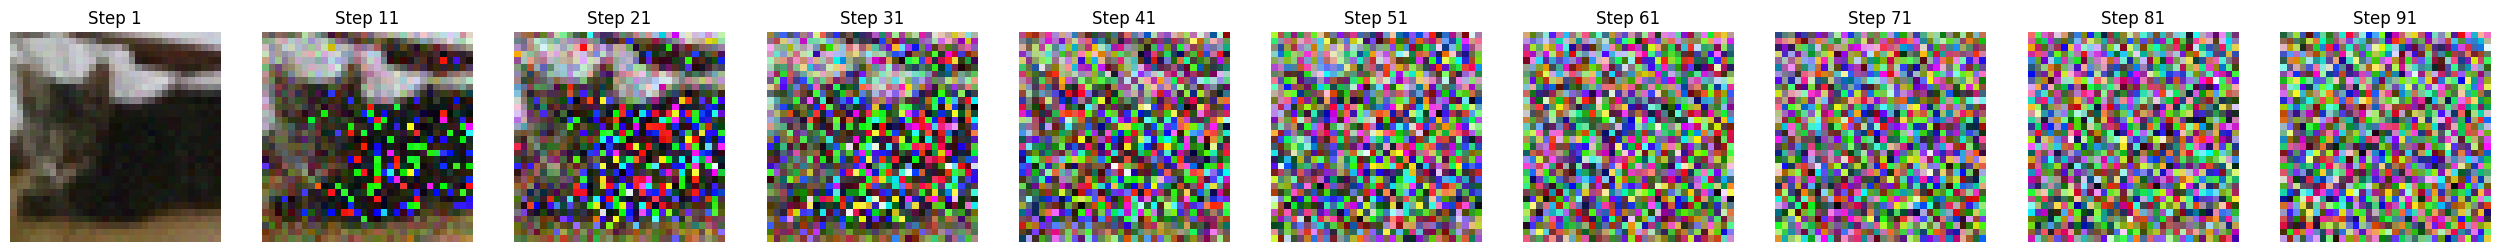

In [15]:
# Pasos (t) a dibujar
steps_to_plot = list(range(0, num_timesteps, 10))

# Revertimos el preprocesado para la correcta visualizacion
reverse_transformations = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

# Seleccionamos un dato
idx_to_plot = 0
x_0 = dataset[idx_to_plot]

# Dibujamos los pasos
fig, axs = plt.subplots(1, len(steps_to_plot), figsize=(32, 16))
axs = axs.flatten()

for idx, step in enumerate(steps_to_plot):
    x_noise, _ = forward_diffusion_sample(x_0=x_0, t=step, alphas_hat_schedule=alphas_hat_schedule) # Añadimos ruido
    x_noise = reverse_transformations(x_noise) # Revertimos el preprocesado
    axs[idx].imshow(x_noise, cmap='gray')
    axs[idx].set_title(f'Step {step+1}')
    axs[idx].axis('off')

plt.show()

### Positional embedding

Como hemos visto en clase, para evitar grandes costos computacionales, en vez de entrenar un modelo distinto para cada paso en el *backward process*, entrenamos un único modelo:

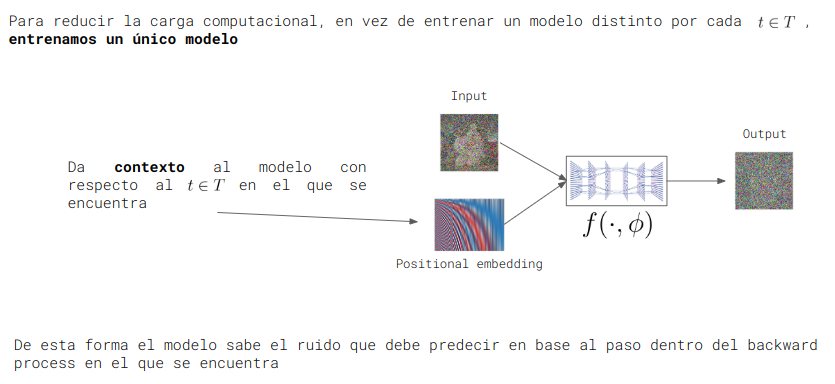

Para que el modelo sea capaz de predecir un nivel de ruido distinto en base al paso $t$ en el que se encuentra le pasamos como input información del paso. Esto se podría hacer pasandole directamente el correspondiente $t \in \mathbb{R}$, sin embargo esto no suele ser lo recomendable. Como alternativa, para cada paso $t$, se genera lo que se conoce como un *positional embedding*. Para un paso de tiempo $t$ y una *embedding dimension* $d$, el *positional embedding* se define de la siguiente forma:

$$PE(t, 2i) = \sin\left(\frac{t}{10000^{\frac{2i}{d}}}\right)$$
$$PE(t, 2i+1) = \cos\left(\frac{t}{10000^{\frac{2i}{d}}}\right)$$


donde $i$ es el índice de la dimensión. Esto nos permite asignar a cada paso un vector único caracterizando su posición, en vez de un solo valor. 

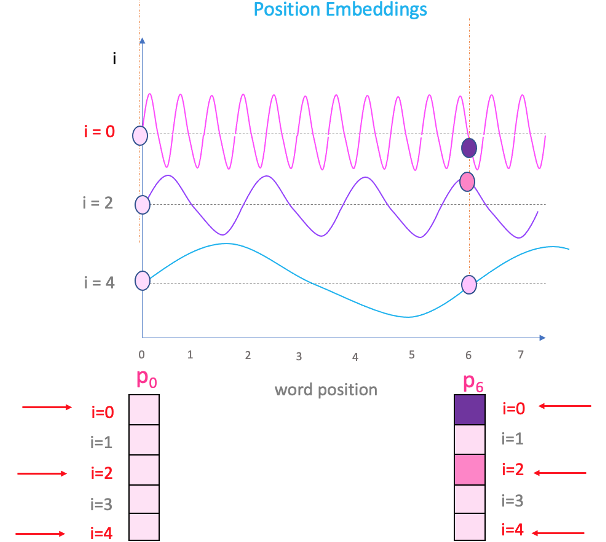

El vector resultante se puede asemejar a la hora dada por un reloj. En este caso, cada una de las dimensiones del vector se corresponde con un *grado de presición en el tiempo* (e.g., hora, minuto y segundo), y su combinación nos da un vector único para cada periodo de tiempo.

In [16]:
def get_sinusoidal_positional_encoding(seq_len, dim):
    # Inicializamos una matriz vacia
    emb_matrix = torch.zeros(seq_len, dim)
    
    # Fijamos n
    n = 10000

    # Iteramos sobre los pasos (t)
    for k in range(seq_len):
        # Iteramos sobre la dimension del embedding
        for i in np.arange(int(dim/2)):
            denominator = torch.tensor(n ** (2*i/dim))
            emb_matrix[k, 2*i] = torch.sin(k/denominator) # Senos para los pares
            emb_matrix[k, 2*i+1] = torch.cos(k/denominator) # Cosenos para los impares
    return emb_matrix

In [17]:
# Calculamos la matriz de positional embeddings
emb_matrix = get_sinusoidal_positional_encoding(seq_len=num_timesteps, dim=512)

A continuación podemos visualizar la matriz de embeddings resultantes

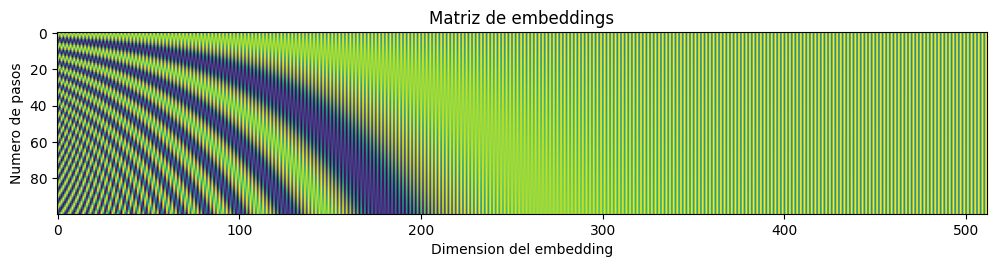

In [18]:
plt.figure(figsize=(12, 4))
plt.imshow(emb_matrix.numpy(),
           vmin=-1, vmax=1)
plt.xlabel('Dimension del embedding')
plt.ylabel('Numero de pasos')
plt.title('Matriz de embeddings')
plt.show()

Así como algunos vectores de forma individualizada

In [19]:
step_to_plot = 0
print(f'Embedding para el paso {step_to_plot+1}')

plt.figure(figsize=(50, 4))
plt.imshow(emb_matrix[None, step_to_plot].numpy(),
           vmin=-1, vmax=1)
plt.axis('off')
plt.show()

Embedding para el paso 1


In [20]:
step_to_plot = 49
print(f'Embedding para el paso {step_to_plot+1}')

plt.figure(figsize=(50, 4))
plt.imshow(emb_matrix[None, step_to_plot].numpy(),
           vmin=-1, vmax=1)
plt.axis('off')
plt.show()

Embedding para el paso 50


In [21]:
step_to_plot = 71
print(f'Embedding para el paso {step_to_plot+1}')

plt.figure(figsize=(50, 4))
plt.imshow(emb_matrix[None, step_to_plot].numpy(),
           vmin=-1, vmax=1)
plt.axis('off')
plt.show()

Embedding para el paso 72


In [22]:
step_to_plot = 72
print(f'Embedding para el paso {step_to_plot+1}')

plt.figure(figsize=(50, 4))
plt.imshow(emb_matrix[None, step_to_plot].numpy(),
           vmin=-1, vmax=1)
plt.axis('off')
plt.show()

Embedding para el paso 73


### Deep learning model

Con respecto al modelo de deep learning a utilizar para aprender el *backward process* vamos a utilizar una U-Net, parecida a la que hemos visto en la práctica de convoluciones y capas residuales.

Primero vamos a definir una clase para el *positional embedding*, a fin de poder obtener el correspondiente vector de *embedding* dado un paso de tiempo *t*.

In [23]:
class positional_embedding(nn.Module):
    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim # Dimension del positional embedding
        self.device = device
        self.n = 10000

    def forward(self, time):
        batch_size = time.shape[0] # Tenemos en cuenta el batch size para evitar problemas con las dimensiones
        device = time.device
        emb_vector = torch.zeros(batch_size, self.dim)
        for i in np.arange(int(self.dim/2)): # Iteramos sobre las dimensiones del positional embedding embedding
            denominator = torch.tensor(self.n ** (2*i/self.dim))
            emb_vector[:, 2*i] = torch.sin(time/denominator).squeeze(-1) # Para los pares aplicamos el seno
            emb_vector[:, 2*i+1] = torch.cos(time/denominator).squeeze(-1) # Para los impares aplicamos el coseno
        return emb_vector.to(device) # Devolvemos el correspondiente vector

Al igual que en la práctica anterior, vamos a definir en distintas clases los componentes de la U-Net

In [24]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pos_emb_dim):
        super(conv_block, self).__init__()
        self.pos_emb_dense = nn.Linear(pos_emb_dim, out_channels) # Pasamos el vector de embedding por una capa densa
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
    def forward(self, x, pos_emb):
        pos_emb = self.pos_emb_dense(pos_emb)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        # Para poder concatenar el positional embedding le hacemos un reshape a la dimensión que corresponda
        pos_emb = pos_emb[..., None, None]
        x = x + pos_emb        
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
    
        return x

class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pos_emb_dim):
        super(encoder_block, self).__init__()
        self.pos_emb_dense = nn.Linear(pos_emb_dim, out_channels) # Pasamos el positional embedding por una capa densa
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reducimos dimension
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
    def forward(self, x, pos_emb):
        pos_emb = self.pos_emb_dense(pos_emb)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        skip = x
        
        pooled = self.pool(x)
        
        # Para poder concatenar el positional embedding le hacemos un reshape a la dimensión que corresponda
        pos_emb = pos_emb[..., None, None]
        pooled = pooled + pos_emb
        
        # Second convolution block
        pooled = self.conv2(pooled)
        pooled = self.bn2(pooled)
        pooled = self.relu2(pooled)

        return skip, pooled

class decoder_block(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, kernel_size, pos_emb_dim):
        super(decoder_block, self).__init__()
        self.pos_emb_dense = nn.Linear(pos_emb_dim, out_channels) # Pasamos el positional embedding por una capa densa 
        
        self.upsample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels,
                                           kernel_size=4, stride=2, padding=1) # Recuperamos la dimensión con una convolución transpuesta
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size, padding='same') # Tenemos en cuenta los channels de la skip connection
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
    def forward(self, x, skip, pos_emb):
        pos_emb = self.pos_emb_dense(pos_emb)
        
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1) # Skip connection
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        # Para poder concatenar el positional embedding le hacemos un reshape a la dimensión que corresponda
        pos_emb = pos_emb[..., None, None]
        x = x + pos_emb
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)        
        
        return x

In [25]:
class UNet(nn.Module):
    def __init__(self, pos_emb_dim, device):
        super(UNet, self).__init__()

        # Definimos el generador del positional embedding
        self.pos_emb_gen = positional_embedding(dim=pos_emb_dim, device=device)
        
        # Pasamos el positional embedding por una capa densa 
        self.pos_emb_dense = nn.Linear(in_features=pos_emb_dim,
                                       out_features=pos_emb_dim)
        self.pos_emb_relu = nn.ReLU()
        
        # Encoder
        self.enc1 = encoder_block(in_channels=3, out_channels=32, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.enc2 = encoder_block(in_channels=32, out_channels=64, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.enc3 = encoder_block(in_channels=64, out_channels=128, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.enc4 = encoder_block(in_channels=128, out_channels=256, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        
        # Capa convolucional
        self.bottom = conv_block(in_channels=256, out_channels=512, kernel_size=3,
                                 pos_emb_dim=pos_emb_dim)
        
        # Decoder
        self.dec4 = decoder_block(in_channels=512, skip_channels=256, out_channels=256, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.dec3 = decoder_block(in_channels=256, skip_channels=128, out_channels=128, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.dec2 = decoder_block(in_channels=128, skip_channels=64, out_channels=64, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        self.dec1 = decoder_block(in_channels=64, skip_channels=32, out_channels=32, kernel_size=3,
                                  pos_emb_dim=pos_emb_dim)
        
        # Capa convolucional final
        self.final = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')
        
    def forward(self, x, time):

        # Obtenemos y procesamos el positional embedding
        pos_emb = self.pos_emb_gen(time)
        pos_emb = self.pos_emb_dense(pos_emb)
        pos_emb = self.pos_emb_relu(pos_emb)
        
        # Encoder
        x1, p1 = self.enc1(x, pos_emb) 
        x2, p2 = self.enc2(p1, pos_emb)
        x3, p3 = self.enc3(p2, pos_emb)
        x4, p4 = self.enc4(p3, pos_emb)
        
        # Capa convolucional
        x5 = self.bottom(p4, pos_emb)
        
        # Decoder
        d4 = self.dec4(x5, x4, pos_emb)
        d3 = self.dec3(d4, x3, pos_emb)
        d2 = self.dec2(d3, x2, pos_emb)
        d1 = self.dec1(d2, x1, pos_emb)
        
        # Capa convolucional final
        outputs = self.final(d1)
        return outputs

In [26]:
model = UNet(pos_emb_dim=128, device=device) # Positional embeddings con una dimension de 128
print(model)

UNet(
  (pos_emb_gen): positional_embedding()
  (pos_emb_dense): Linear(in_features=128, out_features=128, bias=True)
  (pos_emb_relu): ReLU()
  (enc1): encoder_block(
    (pos_emb_dense): Linear(in_features=128, out_features=32, bias=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (enc2): encoder_block(
    (pos_emb_dense): Linear(in_features=128, out_features=64, bias=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (po

### Función de coste

Gracias a las reparametrizaciones del modelo y la función de coste, el entrenamiento se reduce a minimizar el MSE entre el $\epsilon$ y el $\hat{\epsilon}_t = f(\mathbf{z}_t, \theta)$ predicho por el modelo de deep learning

In [27]:
loss_function = nn.MSELoss()

### Entrenamiento del modelo

Movemos el modelo al device que tengamos configurado

In [28]:
model = model.to(device)

Definimos el optimizador, en este caso hemos elegido el Adam con un *learning rate* de 0.001

In [29]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Y el número de epochs

In [34]:
num_epochs = 5

Recordemos el algoritmo para entrenar el modelo de difusión:

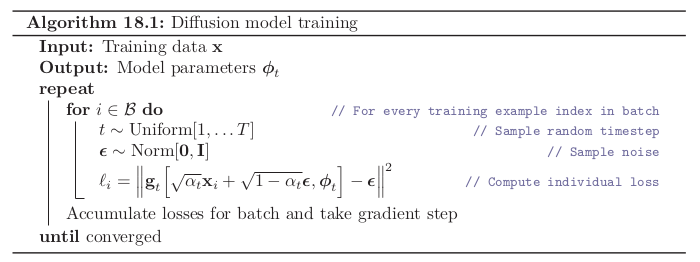

Antes de entrenar el modelo, vamos a mover al device configurado y a cambiar el *shape* de algunos *tensors*

In [35]:
# Les movemos al device configurado
alphas_hat_schedule = alphas_hat_schedule.to(device)
beta_schedule = beta_schedule.to(device)
posterior_variance = posterior_variance.to(device)

In [36]:
# Les cambiamos el shape para permitir el broadcasting
alphas_hat_schedule = alphas_hat_schedule.view(-1, 1, 1, 1)
beta_schedule = beta_schedule.view(-1, 1, 1, 1)
posterior_variance = posterior_variance.view(-1, 1, 1, 1)

Finalmente, siguiendo el algoritmo de arriba, entrenamos el modelo

In [37]:
# Inicializamos una lista para guardar la loss por epoch
loss_train = []

# Iteramos sobre las epochs
for epoch in range(num_epochs):
    model = model.train()
    
    print(f'Epoch {epoch}/{num_epochs}...')
    # Definimos una variable para acumular el valor de la función de coste por epoch
    epoch_loss = 0.0 
    # Iteramos sobre los batches
    for idx, batch_x_data in enumerate(dataloader):
        # Movemos los datos al device
        batch_x_data = batch_x_data.to(device)
        
        # Obtenemos el tamaño de batch_size
        batch_size = batch_x_data.shape[0]
        
        # Hacemos cero los gradientes ya que por defecto estos se acumulan
        optimizer.zero_grad()

        # Sampleamos pasos t de forma aleatoria
        t_samples = torch.randint(0, num_timesteps, (batch_size,)).to(device)

        # Sampleamos el epsilon de una normal estandar
        epsilon_samples = torch.randn_like(batch_x_data).to(device)
        
        # Generamos el dato con ruido (diffusion kernel)
        batch_x_data_noise = torch.sqrt(alphas_hat_schedule[t_samples, :]) * batch_x_data + \
                             torch.sqrt(1 - alphas_hat_schedule[t_samples, :]) * epsilon_samples

        # Pasamos los datos por el modelo
        epsilon_pred = model(batch_x_data_noise, time=t_samples)

        # Calculamos la funcion de coste
        loss_batch = loss_function(epsilon_samples, epsilon_pred) # Comparamos los epsilon
        epoch_loss += batch_size * loss_batch.item()

        # Calculamos los gradientes (backward pass)
        loss_batch.backward()

        # Actualizamos los pesos del modelo
        optimizer.step()

    # Calulamos la loss para la epoch
    epoch_loss = epoch_loss / len(dataset)
    loss_train.append(epoch_loss)
    print(f'Loss function: {epoch_loss}')
    print('')

# Al finalizar el entrenamiento guardamos el modelo (solo los pesos)
model_name = 'diffusion_model.pt'
torch.save(model.state_dict(), model_name)

Epoch 0/5...
Loss function: 0.09843002777099609

Epoch 1/5...
Loss function: 0.09650846691131591

Epoch 2/5...
Loss function: 0.09605152988433838

Epoch 3/5...
Loss function: 0.09432682723999024

Epoch 4/5...
Loss function: 0.0940970726966858



## Inferencia

Una vez entrenado el modelo podemos hacer la inferencia, es decir, generar muestras $\mathbf{x} \in P_{\theta}(\mathbf{X})$ con $P_{\theta}(\mathbf{X}) \sim P(\mathbf{X})$. Para ello debemos implementar el siguiente algoritmo:

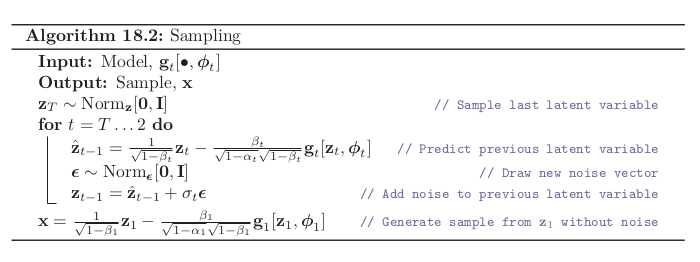

In [38]:
def diffusion_sampling(model, input_data_dim, device,
                       num_timesteps, beta_schedule, alphas_hat_schedule, posterior_variance):

    '''
    model: El modelo a utilizar para hacer la inferencia
    input_data_dim: La dimension de los datos de entrada, con dimension batch_size
    device: Device sobre el que hacer la inferencia
    num_timesteps: T usado para definir el diffusion process
    beta_shedule: Noise schedule
    alphas_hat_schedule: Los alphas calculados a partir de las betas
    posterior variance: Varianza de las normales al samplear q(z_{t-1} | z_{t})
    '''

    # Creamos una lista vacía para almacenar todas las z_t
    z_list = []

    # Llevamos el modelo al device configurado
    model = model.to(device)

    # Ponemos al modelo en modo evaluación
    model = model.eval()

    # Sampleamos z_T de una normal estandar
    z_t = torch.randn(input_data_dim).to(device)
    z_list.append(z_t)

    # Iteramos desde z_T a \hat{x}
    for t in range(0, num_timesteps)[::-1]:
        with torch.no_grad(): # Evitamos calcular gradientes, no los necesitamos
            # Generamos un tensor con el t en el que nos encontremos
            t_tensor = torch.tensor([t,]).to(device)

            # Calculamos el epsilon con el modelo de deep learning
            epsilon_pred = model(z_t, t_tensor)

            # Calculamos el \hat{z}_{t-1} (Previous latent variable)
            z_hat_t_1 = (1 / (torch.sqrt(1-beta_schedule[t, :][None, :, :, :]))) * z_t  - \
                        (beta_schedule[t]/(torch.sqrt(1-alphas_hat_schedule[t, :][None, :, :, :]) * torch.sqrt(1-beta_schedule[t, :][None, :, :, :]))) * epsilon_pred
            
            # Sampleamos de una normal para la desviación de la normal de la siguiente variable latente
            epsilon = torch.randn_like(z_hat_t_1)
            
            if t == 0: # Si estamos ante el último paso en el backward process devolvemos la predicción
                x_gen = z_hat_t_1
                z_list.append(x_gen)
            else: # Si no sampleamos de la normal, teniendo en cuenta la posterior variance
                z_t = z_hat_t_1 + torch.sqrt(posterior_variance[t, :])[None, :, :, :] * epsilon
                z_list.append(z_t)

    # Devolvemos todos los z_{1...T}
    return z_list

Cargamos el modelo entrenado

In [39]:
model = UNet(pos_emb_dim=128, device=device)
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

Generamos una muestra llamando a la función `diffusion_sampling`

In [40]:
z_sampling = diffusion_sampling(model=model, input_data_dim=(1, 3, 32, 32),
                                device=device,
                                num_timesteps=num_timesteps,
                                beta_schedule=beta_schedule,
                                alphas_hat_schedule=alphas_hat_schedule,
                                posterior_variance=posterior_variance)

Dibujamos algunas de las $z_{1...T}$, incluyendo la predicción final $\hat{\mathbf{x}}$

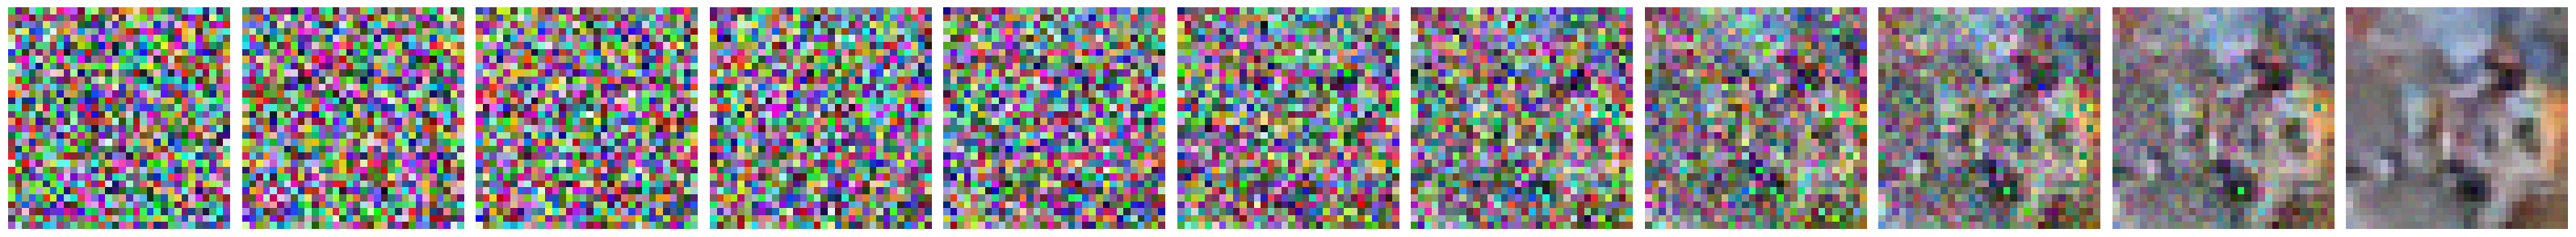

In [41]:
n = len(z_sampling)
rows, cols = 1, 11

plt.close()
fig, axes = plt.subplots(rows, cols, figsize=(32, 16))
axes = axes.flatten() 

steps_to_plot = list(range(0, num_timesteps-1, num_timesteps // 10)) + [num_timesteps-1]
for i, t in enumerate(steps_to_plot):
    img = reverse_transformations(z_sampling[t][0, :].to('cpu'))
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### References

**[1]** https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

**[2]** https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model

**[3]** https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

**[4]** https://cabralpinto.github.io/modular-diffusion/modules/noise-schedule/